# Set-Up

In [ ]:
# Install Requirements

!pip install -r requirements.txt

In [1]:
# Import packages

import os
import json
import numpy as np
import rasterio
from rasterio.windows import Window, from_bounds
from rasterio.merge import merge
from rasterio.warp import transform_bounds
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Patching

In [2]:
# Config

# Set patching parameters
patch_size = 256  
stride = 128      
valid_threshold = 0.7
num_regions = 10

# Set paths to input and output directories
s2_dir = "/cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/cambridge_sentinel_downloads"
lidar_dir = "/cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/cambridge_lidar"
out_lidar_dir = "/cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/input_data/lidar_patches_cambridge"
out_s2_dir = "/cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/input_data/s2_patches_cambridge"
os.makedirs(out_lidar_dir, exist_ok=True)
os.makedirs(out_s2_dir, exist_ok=True)

# Sentinel Directory Logic

# Get a list of all subdirectories
s2_safes = [d for d in Path(s2_dir).iterdir() if d.is_dir()]

# Generate paths to metadata files
sentinel_meta_jsons = [str(sf) + "_metadata.json" for sf in s2_safes]

# Get granules 
sentinel_granule_dirs = []
for s2_safe in s2_safes:
    product_name_path = [d for d in s2_safe.iterdir() if d.is_dir()]
    granule_path = os.path.join(product_name_path[0], "GRANULE")
    sentinel_granule_dirs.append(granule_path)

# Sort sentinel granule directories by name to get chosen product order from best to worst
sentinel_granule_dirs = sorted(sentinel_granule_dirs)

In [3]:
# Merge LiDAR files

def merge_lidar_files(lidar_files):
    src_files = [rasterio.open(fp) for fp in lidar_files]
    mosaic, mosaic_transform = merge(src_files,nodata=-9999,dtype='float32')
    lidar_meta = src_files[0].meta.copy()
    lidar_meta.update({
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": mosaic_transform,
        "nodata": -9999
    })
    for src in src_files:
        src.close()
    return mosaic[0], mosaic_transform, lidar_meta

lidar_files = glob(os.path.join(lidar_dir, "*.tif"))
lidar_array, lidar_transform, lidar_meta = merge_lidar_files(lidar_files)
lidar_crs = lidar_meta["crs"]
s2_patch_size = patch_size // 10
# Replace -9999 with NaN
lidar_array = np.where(lidar_array == -9999, np.nan, lidar_array)

Total valid patches: 2033
Balanced Patch Counts:
Region 0: 204 patches
Region 1: 204 patches
Region 2: 204 patches
Region 3: 203 patches
Region 4: 203 patches
Region 5: 203 patches
Region 6: 203 patches
Region 7: 203 patches
Region 8: 203 patches
Region 9: 203 patches


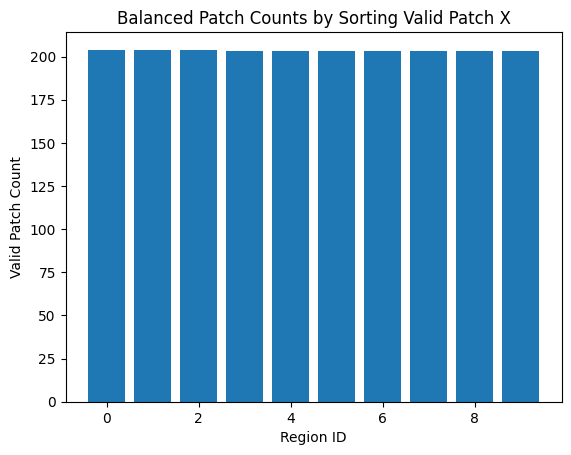

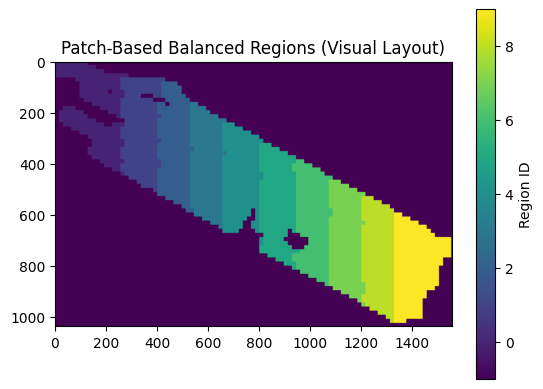

In [5]:
# Divide LiDAR region into 10 balanced regions

# Get lidar bounds
H, W = lidar_array.shape
mask = ~np.isnan(lidar_array)

# Slide window and store all valid patch positions (x, y)
patches = []

for y in range(0, H - patch_size + 1, stride):
    for x in range(0, W - patch_size + 1, stride):
        patch_mask = mask[y:y + patch_size, x:x + patch_size]
        if patch_mask.mean() >= valid_threshold:
            patches.append((x, y))

patches = np.array(patches)
print(f"Total valid patches: {len(patches)}")

# Sort by x (patch start)
sorted_patches = patches[np.argsort(patches[:, 0])]

# Split into 10 equal-size groups
patch_bins = np.array_split(sorted_patches, num_regions)
region_patch_indices = [list(bin) for bin in patch_bins]

# Count patches
region_patch_counts = [len(r) for r in region_patch_indices]
print("Balanced Patch Counts:")
for i, count in enumerate(region_patch_counts):
    print(f"Region {i}: {count} patches")

# Plot
plt.bar(range(num_regions), region_patch_counts)
plt.xlabel("Region ID")
plt.ylabel("Valid Patch Count")
plt.title("Balanced Patch Counts by Sorting Valid Patch X")
plt.show()

# Generate region overlay map
overlay = np.full_like(lidar_array, -1, dtype=int)

for region_id, patch_list in enumerate(region_patch_indices):
    for x, y in patch_list:
        overlay[y:y+patch_size, x:x+patch_size] = region_id

# Downsample for speed
overlay_vis = overlay[::8, ::8]

plt.imshow(overlay_vis)
plt.title("Patch-Based Balanced Regions (Visual Layout)")
plt.colorbar(label="Region ID")
plt.show()


In [ ]:
# Stack S2 Bands
def stack_sentinel_bands(safe_granule_path):
    band_files = {}
    for band in ["B02", "B03", "B04", "B08"]:
        pattern = os.path.join(safe_granule_path, "**", f"*_{band}_10m.jp2")
        matches = glob(pattern, recursive=True)
        if not matches:
            raise FileNotFoundError(f"Could not find band {band} in {safe_granule_path}.")
        band_files[band] = matches[0]

    band_stack = []
    meta = None
    for band in ["B04", "B03", "B02", "B08"]:
        with rasterio.open(band_files[band]) as src:
            band_stack.append(src.read(1))
            if meta is None:
                meta = src.meta.copy()
    stacked = np.stack(band_stack, axis=0)  
    return stacked, meta

def load_json_safe(path):
    if path is None or not os.path.exists(path):
        return None
    with open(path, "r") as f:
        return json.load(f)

sentinel_products = []
for i, gdir in enumerate(sentinel_granule_dirs):
    stack, meta = stack_sentinel_bands(gdir)
    sentinel_products.append({
        "stack": stack,
        "meta": meta,
        "transform": meta["transform"],
        "crs": meta["crs"],
        "attrs": load_json_safe(sentinel_meta_jsons[i])
    })
    
# Extract patches by region or full-scan (test)
def extract_lidar_multi_s2_by_region(
    lidar_array, lidar_transform, lidar_crs,
    sentinel_products,
    patch_size, s2_patch_size,
    out_lidar_dir, out_s2_dir,
    region_patch_indices,
    start_idx=0):

    print("Extracting patches by region...")

    lidar_array = np.where(lidar_array == -9999, np.nan, lidar_array)
    count = 0

    region_iter = list(enumerate(region_patch_indices))

    for region_id, patch_list in region_iter:
        for x, y in patch_list:
            lid_win = Window(x, y, patch_size, patch_size)
            lid_bounds = rasterio.windows.bounds(lid_win, lidar_transform)
            lid_patch_raw = lidar_array[y:y+patch_size, x:x+patch_size]
            valid_mask = ~np.isnan(lid_patch_raw)
            if valid_mask.mean() < valid_threshold:
                continue

            lid_patch = np.nan_to_num(lid_patch_raw, nan=0.0)
            lid_mask = valid_mask.astype(np.uint8)
            lidar_patch = np.stack([lid_patch, lid_mask], axis=0)

            s2_patches, s2_transforms, ok = [], [], True
            for prod in sentinel_products:
                try:
                    s2_bounds = transform_bounds(lidar_crs, prod["crs"], *lid_bounds, densify_pts=21)
                    s2_window = from_bounds(*s2_bounds, prod["transform"])
                    s2_row = int(s2_window.row_off)
                    s2_col = int(s2_window.col_off)
                    s2_patch = prod["stack"][:, s2_row:s2_row + s2_patch_size, s2_col:s2_col + s2_patch_size]
                    if s2_patch.shape[1:] != (s2_patch_size, s2_patch_size):
                        ok = False
                        break
                    s2_patches.append(s2_patch)
                    s2_transforms.append(rasterio.windows.transform(s2_window, prod["transform"]))
                except Exception:
                    ok = False
                    break

            if not ok or len(s2_patches) != len(sentinel_products):
                continue

            patch_id = f"{start_idx + count:05d}"
            lid_out = os.path.join(out_lidar_dir, f"lidar_patch_{patch_id}.tif")
            lid_meta = {
                "driver": "GTiff",
                "height": patch_size,
                "width": patch_size,
                "count": 2,
                "dtype": lidar_patch.dtype,
                "crs": lidar_crs,
                "transform": rasterio.windows.transform(lid_win, lidar_transform)
            }
            with rasterio.open(lid_out, "w", **lid_meta) as dst:
                dst.write(lidar_patch)

            patch_dir = os.path.join(out_s2_dir, f"s2_patch_{patch_id}")
            os.makedirs(patch_dir, exist_ok=True)
            attrs_list = []

            for i, (prod, s2_patch, s2_tr) in enumerate(zip(sentinel_products, s2_patches, s2_transforms)):
                s2_meta = prod["meta"].copy()
                s2_meta.update({
                    "count": 4,
                    "height": s2_patch_size,
                    "width": s2_patch_size,
                    "transform": s2_tr
                })
                s2_path = os.path.join(patch_dir, f"t{i}.tif")
                with rasterio.open(s2_path, "w", **s2_meta) as dst:
                    dst.write(s2_patch)

                record = None
                if prod.get("attrs"):
                    a = prod["attrs"]
                    record = {
                        "product_id": a.get("product_id") or a.get("productId"),
                        "product_name": a.get("product_name") or a.get("productName"),
                        "acquisition_date": a.get("acquisition_date"),
                        "cloud_cover": a.get("cloud_cover"),
                        "sun_zenith_mean": a.get("sun_zenith_mean"),
                        "sun_azimuth_mean": a.get("sun_azimuth_mean"),
                        "view_zenith_mean": a.get("view_zenith_mean"),
                        "view_azimuth_mean": a.get("view_azimuth_mean"),
                    }
                attrs_list.append(record)

            with open(os.path.join(patch_dir, "attrs.json"), "w") as jf:
                json.dump(attrs_list, jf, indent=2)

            with open(os.path.join(patch_dir, "region.json"), "w") as jf:
                json.dump({"region_id": region_id+10}, jf)

            count += 1
            if count // 500 > 0 and count % 500 == 0:
                print(f"Processed {count} patches...")

    return count

# Execution

total = extract_lidar_multi_s2_by_region(
    lidar_array=lidar_array,
    lidar_transform=lidar_transform,
    lidar_crs=lidar_crs,
    sentinel_products=sentinel_products,
    patch_size=patch_size,
    s2_patch_size=s2_patch_size,
    out_lidar_dir=out_lidar_dir,
    out_s2_dir=out_s2_dir,
    region_patch_indices=region_patch_indices,  
    start_idx=5000
)

print(f"Extracted {total} LiDAR patches across {num_regions} regions.")

Extracting patches by region...
Processed 500 patches...
Processed 1000 patches...
Processed 1500 patches...
Processed 2000 patches...
Extracted 2033 LiDAR patches across 10 regions.


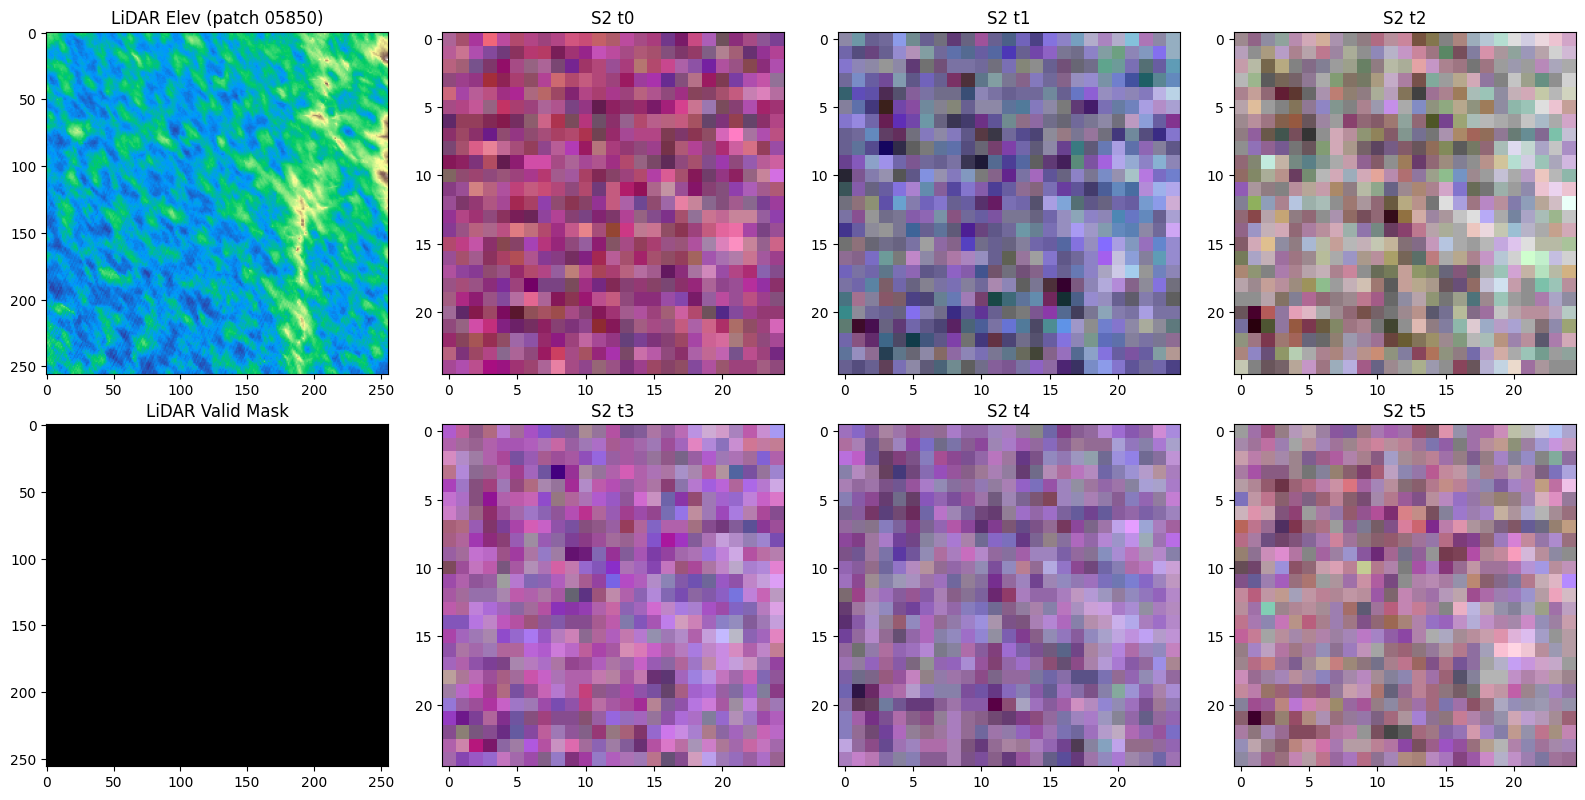

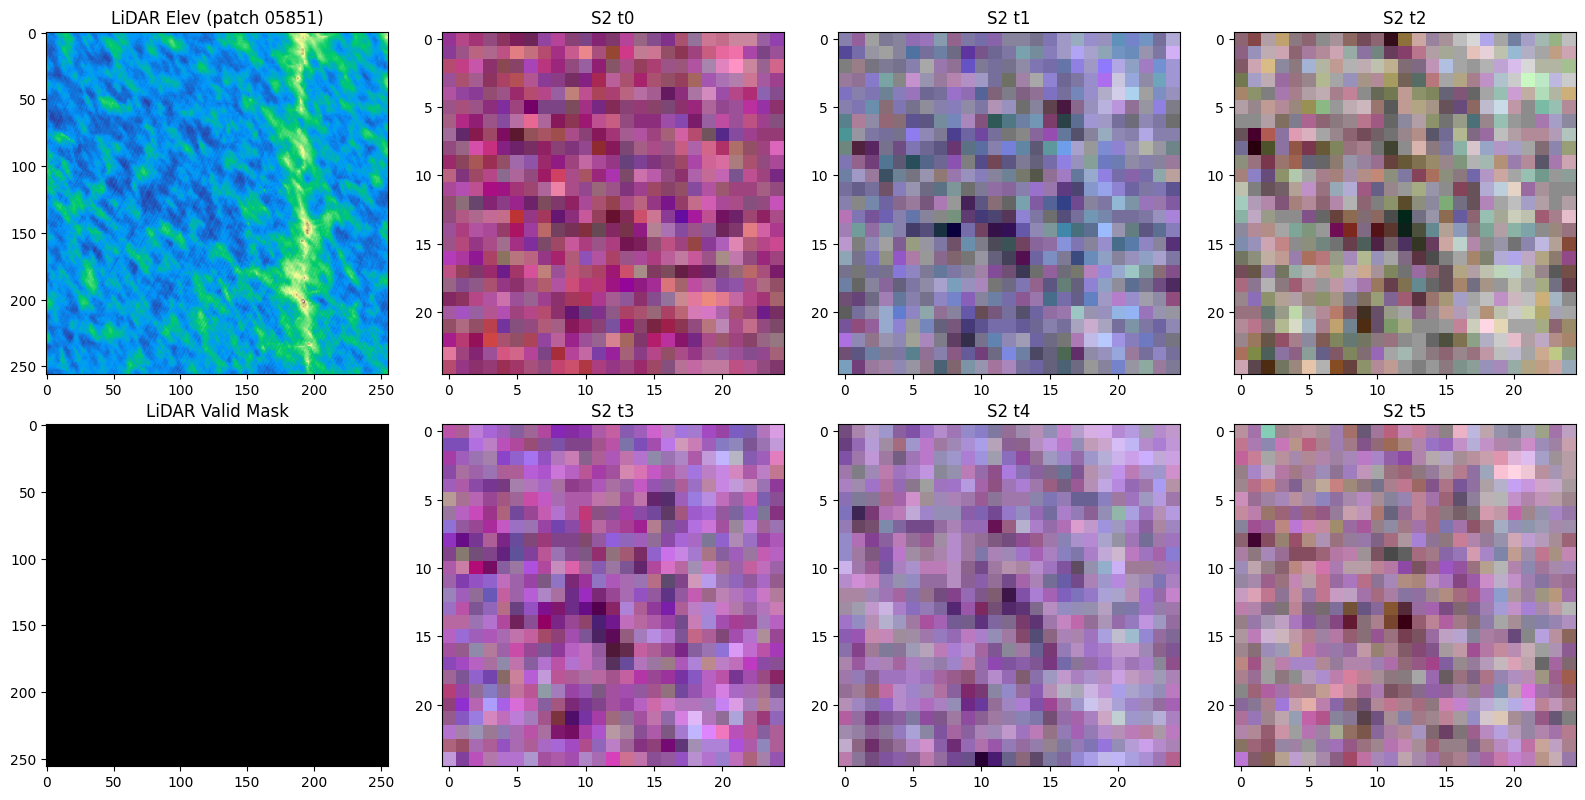

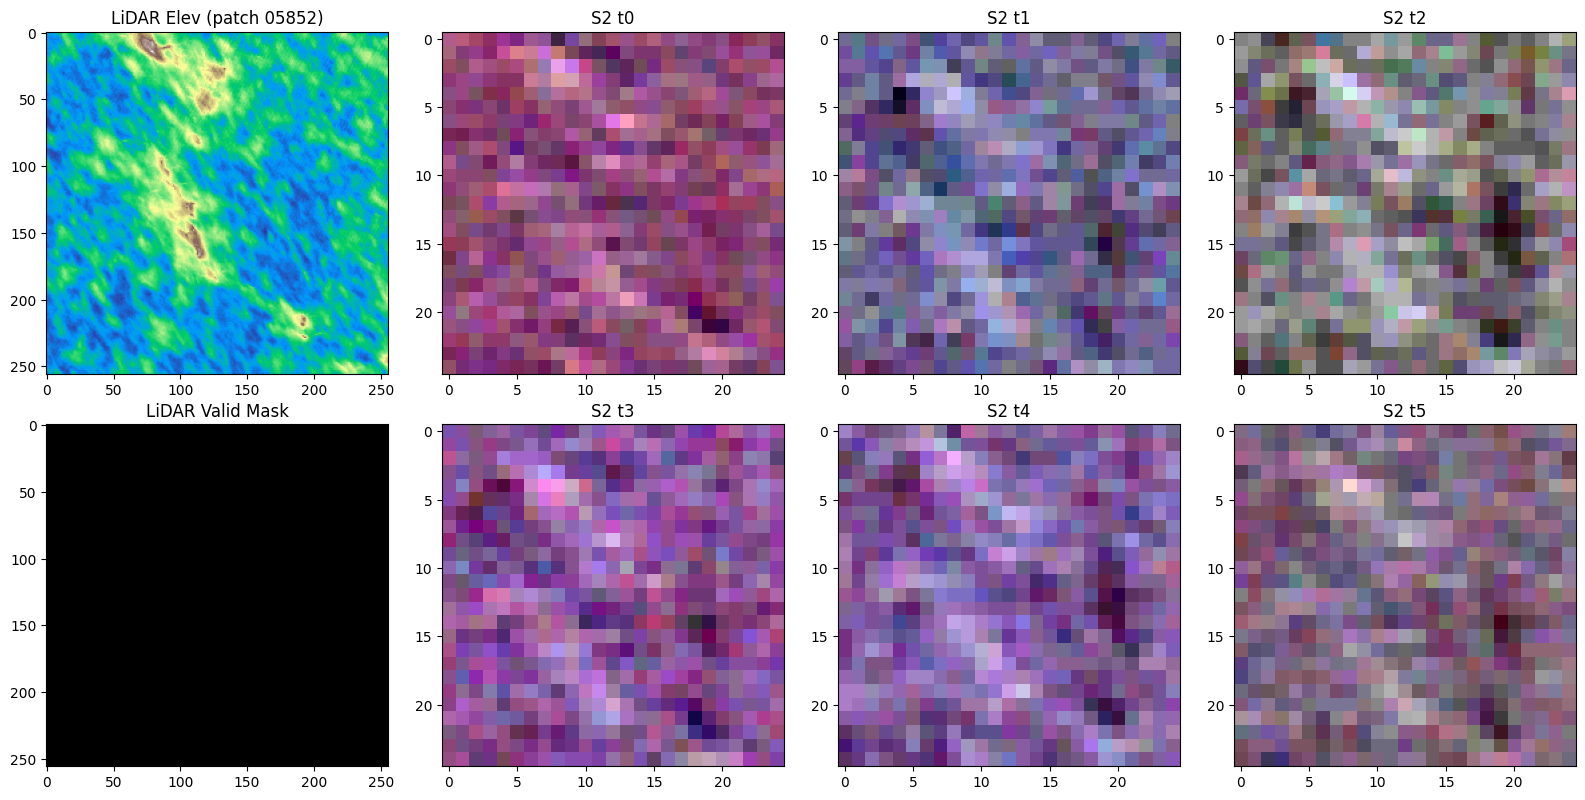

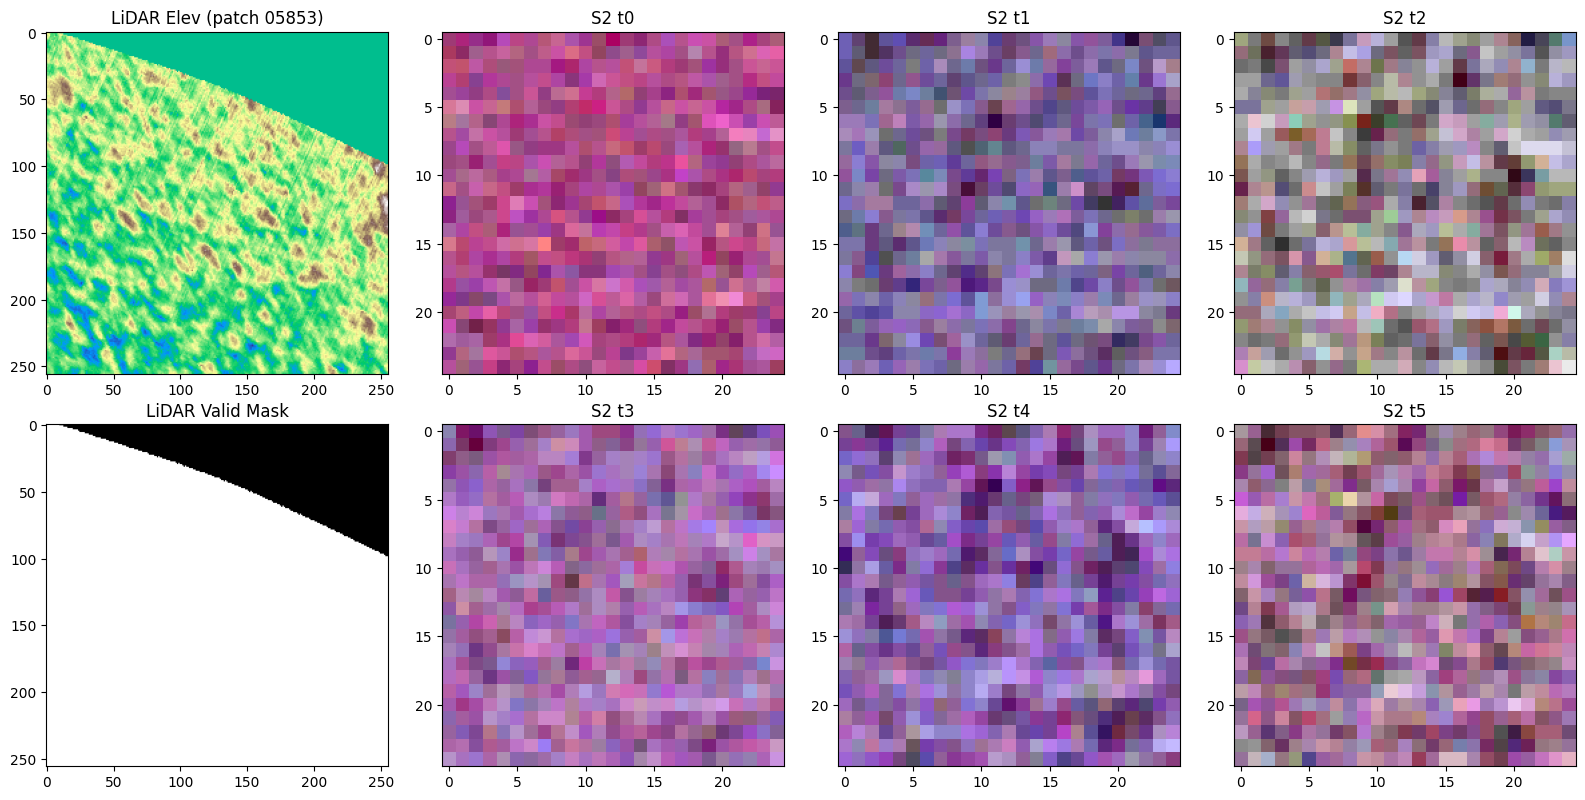

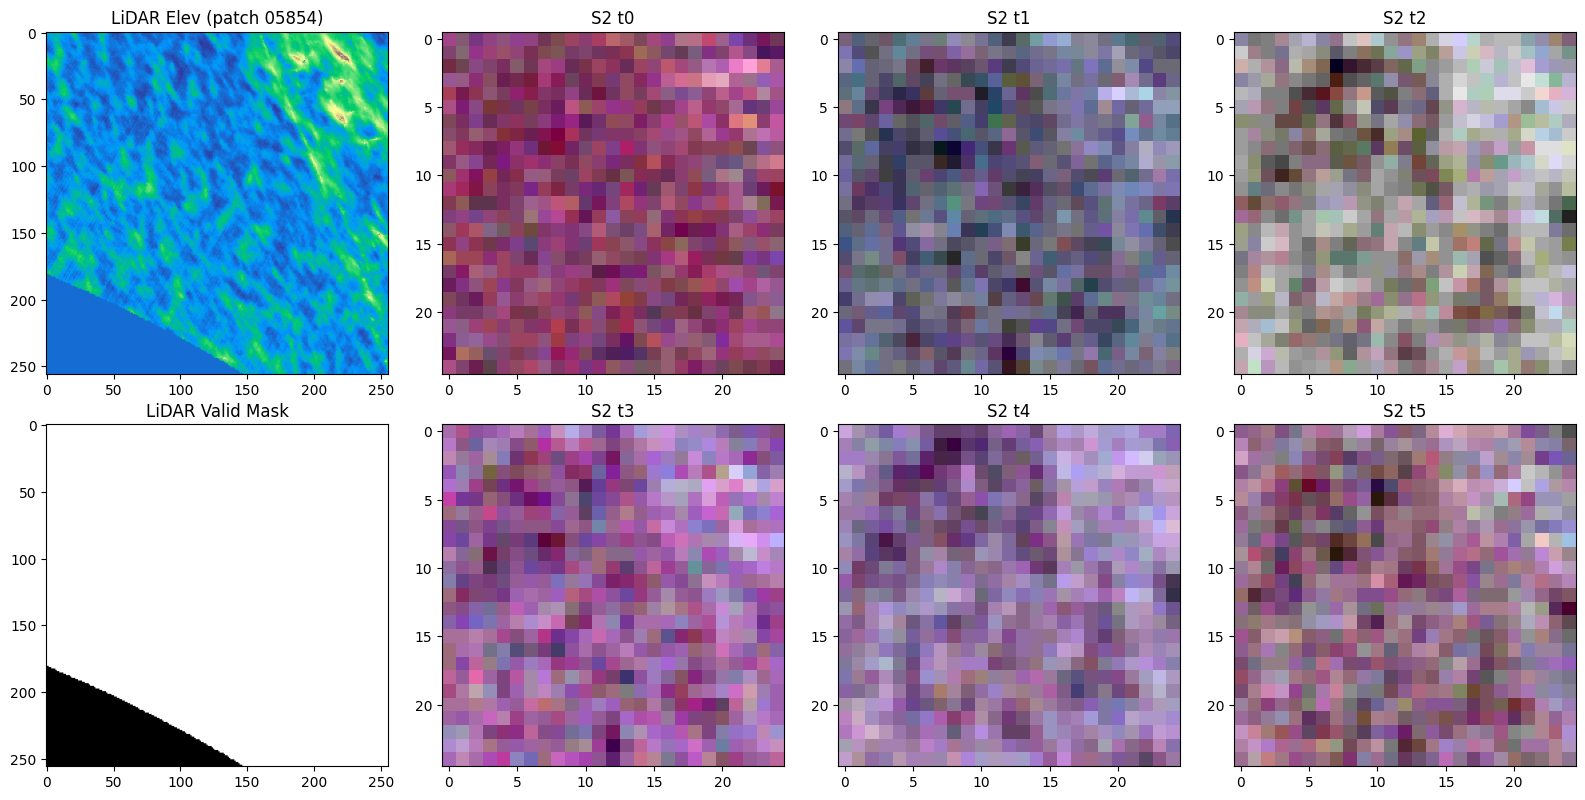

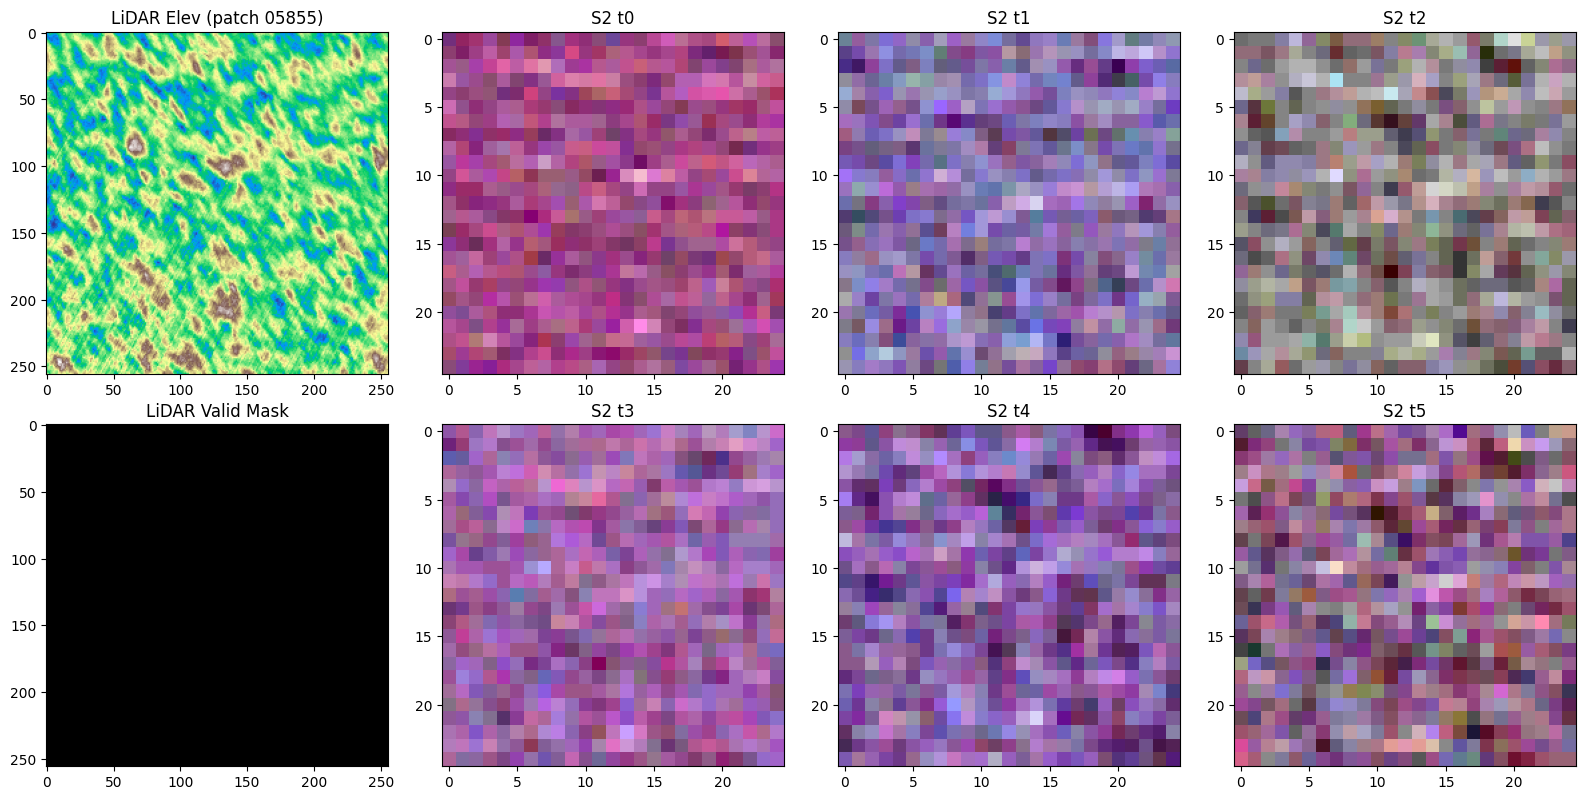

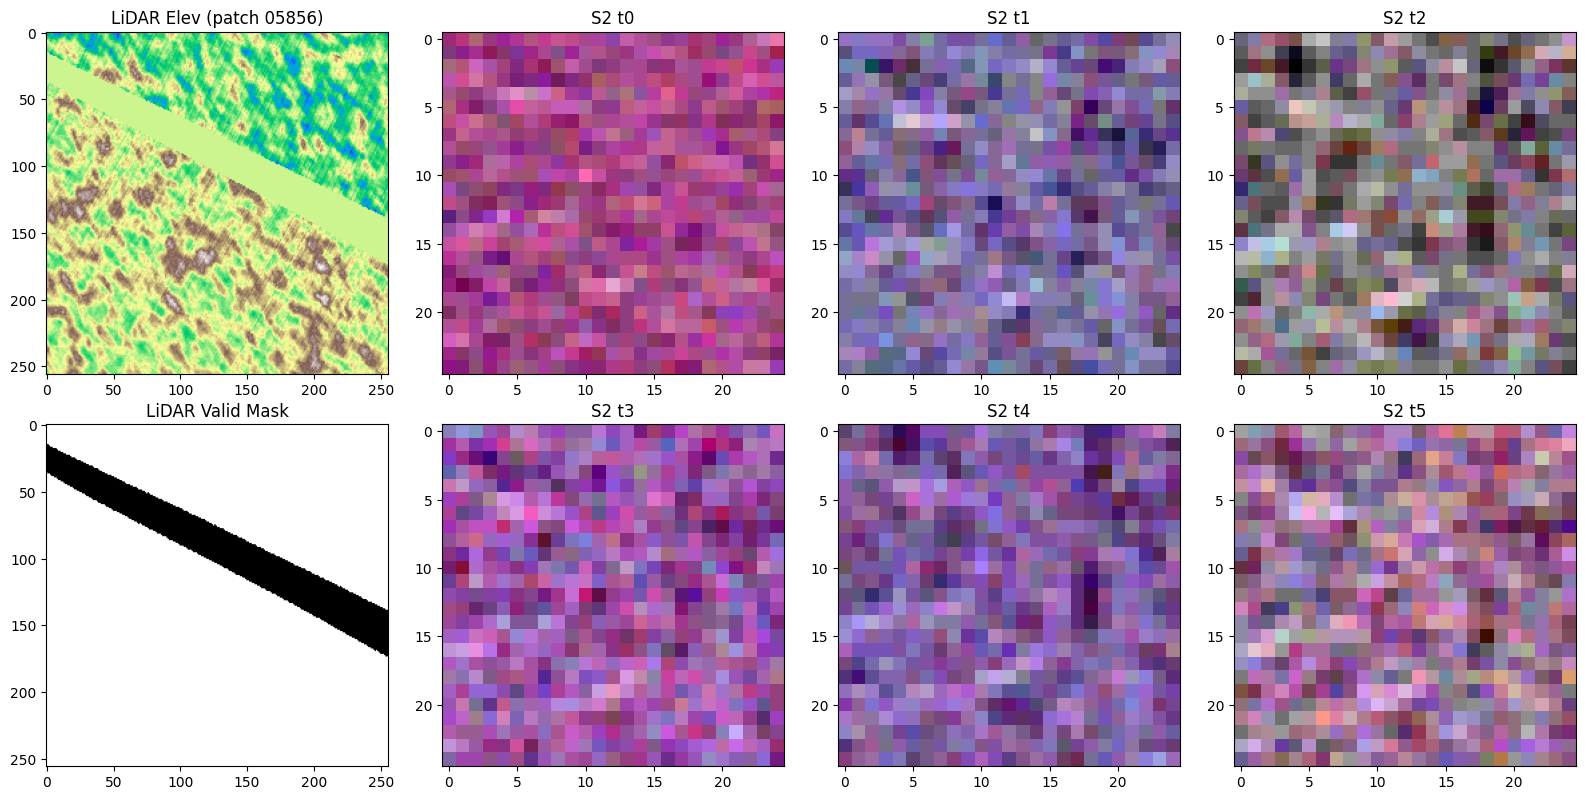

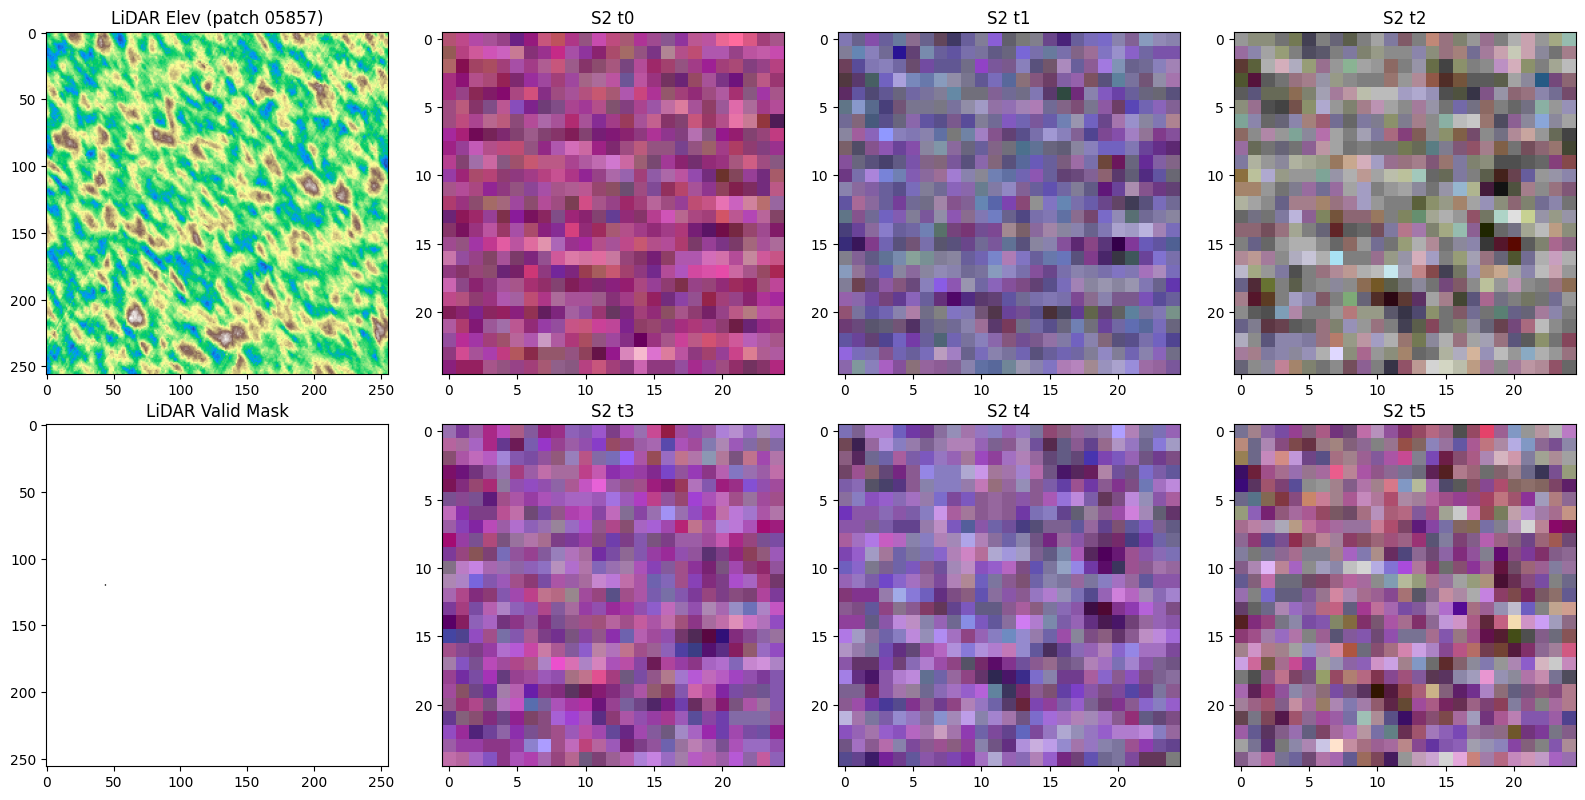

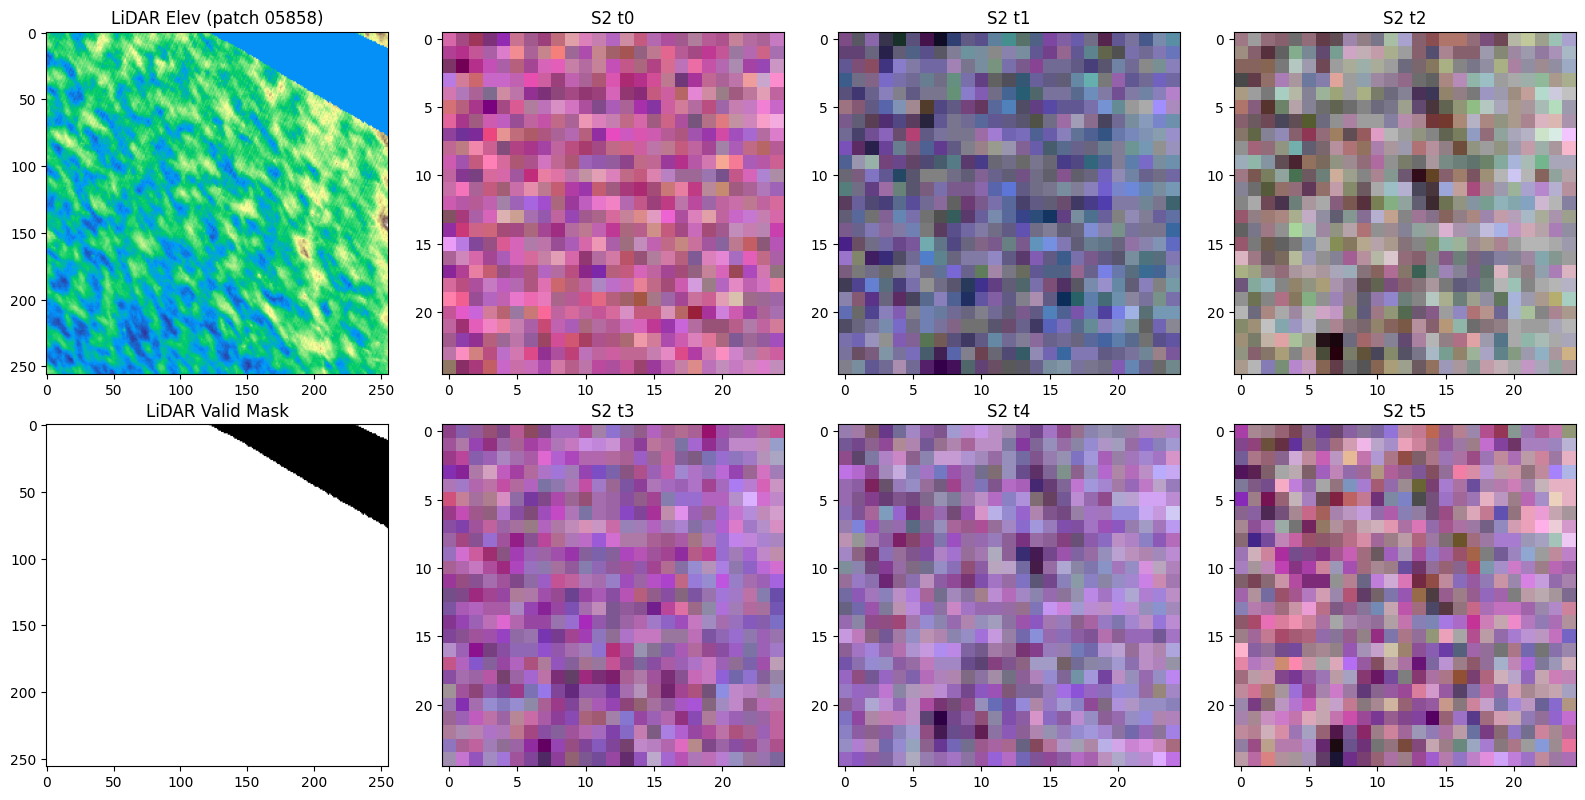

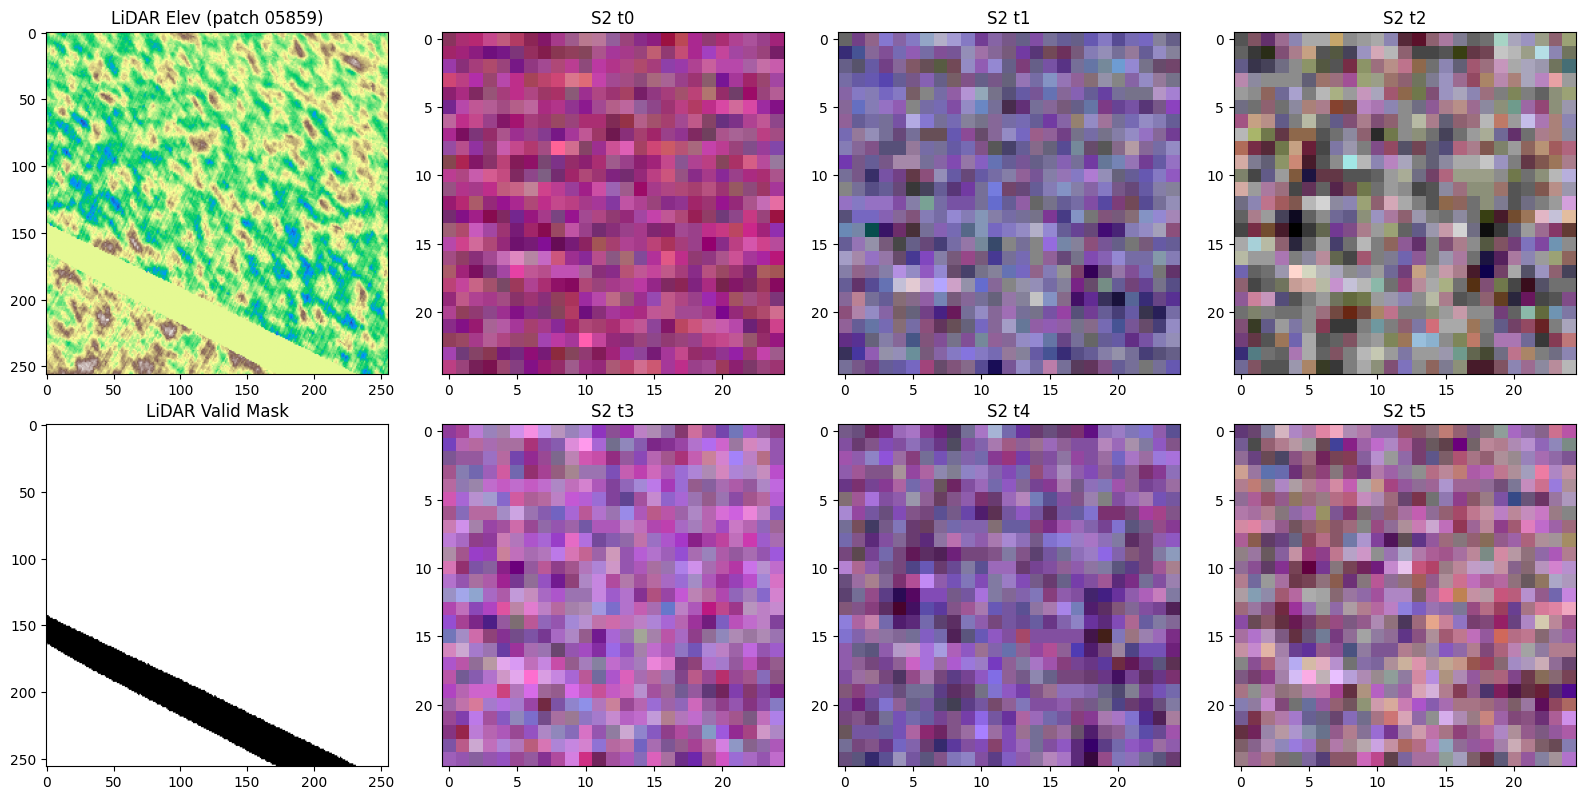

In [22]:
# Visualization
def normalize_01(img):
    img = img.astype(np.float32)
    mn, mx = np.nanmin(img), np.nanmax(img)
    if mx <= mn:
        return np.zeros_like(img)
    return (img - mn) / (mx - mn)

def show_group(patch_id, out_lidar_dir, out_s2_dir):
    lid_path = os.path.join(out_lidar_dir, f"lidar_patch_{patch_id}.tif")
    s2_dir  = os.path.join(out_s2_dir, f"s2_patch_{patch_id}")

    with rasterio.open(lid_path) as src:
        lidar_elev = src.read(1)
        lidar_mask = src.read(2)

    s2_imgs = []
    for i in range(6):
        s2_path = os.path.join(s2_dir, f"t{i}.tif")
        with rasterio.open(s2_path) as src:
            rgb = src.read([1, 2, 3])
        rgb = np.moveaxis(rgb, 0, -1)
        s2_imgs.append(normalize_01(rgb))

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    ax = axes.ravel()

    im0 = ax[0].imshow(lidar_elev, cmap="terrain")
    ax[0].set_title(f"LiDAR Elev (patch {patch_id})")

    im1 = ax[4].imshow(lidar_mask, cmap="gray")
    ax[4].set_title("LiDAR Valid Mask")

    titles = [f"S2 t{i}" for i in range(6)]
    for i in range(3):
        ax[1 + i].imshow(s2_imgs[i])
        ax[1 + i].set_title(titles[i])

    for i in range(3, 6):
        ax[5 + (i - 3)].imshow(s2_imgs[i])
        ax[5 + (i - 3)].set_title(titles[i])

    for a in ax:
        if not hasattr(a.images, "__len__") or len(a.images) == 0:
            a.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize first few samples
sample_lidar = sorted(glob(os.path.join(out_lidar_dir, "lidar_patch_05*.tif")))[850:860]
for p in sample_lidar:
    pid = os.path.splitext(os.path.basename(p))[0].split("_")[-1]
    show_group(pid, out_lidar_dir, out_s2_dir)

# Additional Data Visualizations

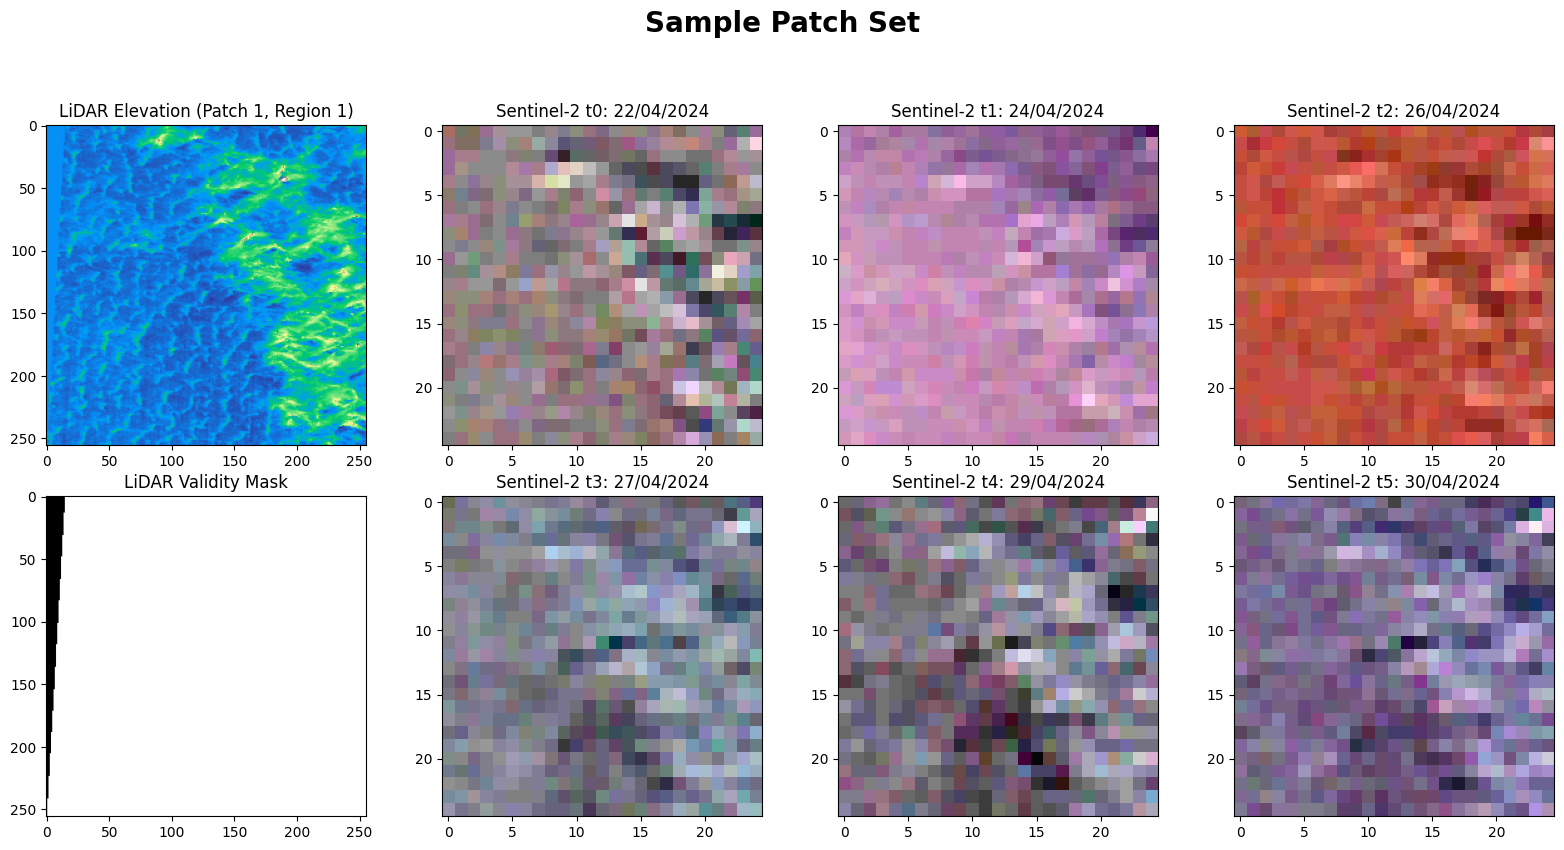

In [30]:
# Visualization

def normalize_01(img):
    img = img.astype(np.float32)
    mn, mx = np.nanmin(img), np.nanmax(img)
    if mx <= mn:
        return np.zeros_like(img)
    return (img - mn) / (mx - mn)

def show_group(patch_id, out_lidar_dir, out_s2_dir):
    lid_path = os.path.join(out_lidar_dir, f"lidar_patch_{patch_id}.tif")
    s2_dir  = os.path.join(out_s2_dir, f"s2_patch_{patch_id}")
    
    with rasterio.open(lid_path) as src:
        lidar_elev = src.read(1)
        lidar_mask = src.read(2)
    
    s2_imgs = []
    for i in range(6):
        s2_path = os.path.join(s2_dir, f"t{i}.tif")
        with rasterio.open(s2_path) as src:
            rgb = src.read([1, 2, 3])
        rgb = np.moveaxis(rgb, 0, -1)
        s2_imgs.append(normalize_01(rgb))
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle("Sample Patch Set", fontsize=20, fontweight='bold', y=1.05)
    ax = axes.ravel()
    
    # Titles for each subplot in the requested order
    plot_titles = [
        "LiDAR Elevation (Patch 1, Region 1)",
        "Sentinel-2 t0: 22/04/2024",
        "Sentinel-2 t1: 24/04/2024",
        "Sentinel-2 t2: 26/04/2024",
        "LiDAR Validity Mask",
        "Sentinel-2 t3: 27/04/2024",
        "Sentinel-2 t4: 29/04/2024",
        "Sentinel-2 t5: 30/04/2024"
    ]
    
    # Order: elev, s2_0, s2_1, s2_2, mask, s2_3, s2_4, s2_5
    ax[0].imshow(lidar_elev, cmap="terrain")
    ax[0].set_title(plot_titles[0])
    
    ax[1].imshow(s2_imgs[0])
    ax[1].set_title(plot_titles[1])
    
    ax[2].imshow(s2_imgs[1])
    ax[2].set_title(plot_titles[2])
    
    ax[3].imshow(s2_imgs[2])
    ax[3].set_title(plot_titles[3])
    
    ax[4].imshow(lidar_mask, cmap="gray")
    ax[4].set_title(plot_titles[4])
    
    ax[5].imshow(s2_imgs[3])
    ax[5].set_title(plot_titles[5])
    
    ax[6].imshow(s2_imgs[4])
    ax[6].set_title(plot_titles[6])
    
    ax[7].imshow(s2_imgs[5])
    ax[7].set_title(plot_titles[7])
    
    for a in ax:
        if not hasattr(a.images, "__len__") or len(a.images) == 0:
            a.axis("off")
    
    plt.tight_layout()
    plt.show()

sample_lidar = glob(os.path.join(out_lidar_dir, "lidar_patch_00001.tif"))
pid = os.path.splitext(os.path.basename(sample_lidar[0]))[0].split("_")[-1]
show_group(pid, out_lidar_dir, out_s2_dir)

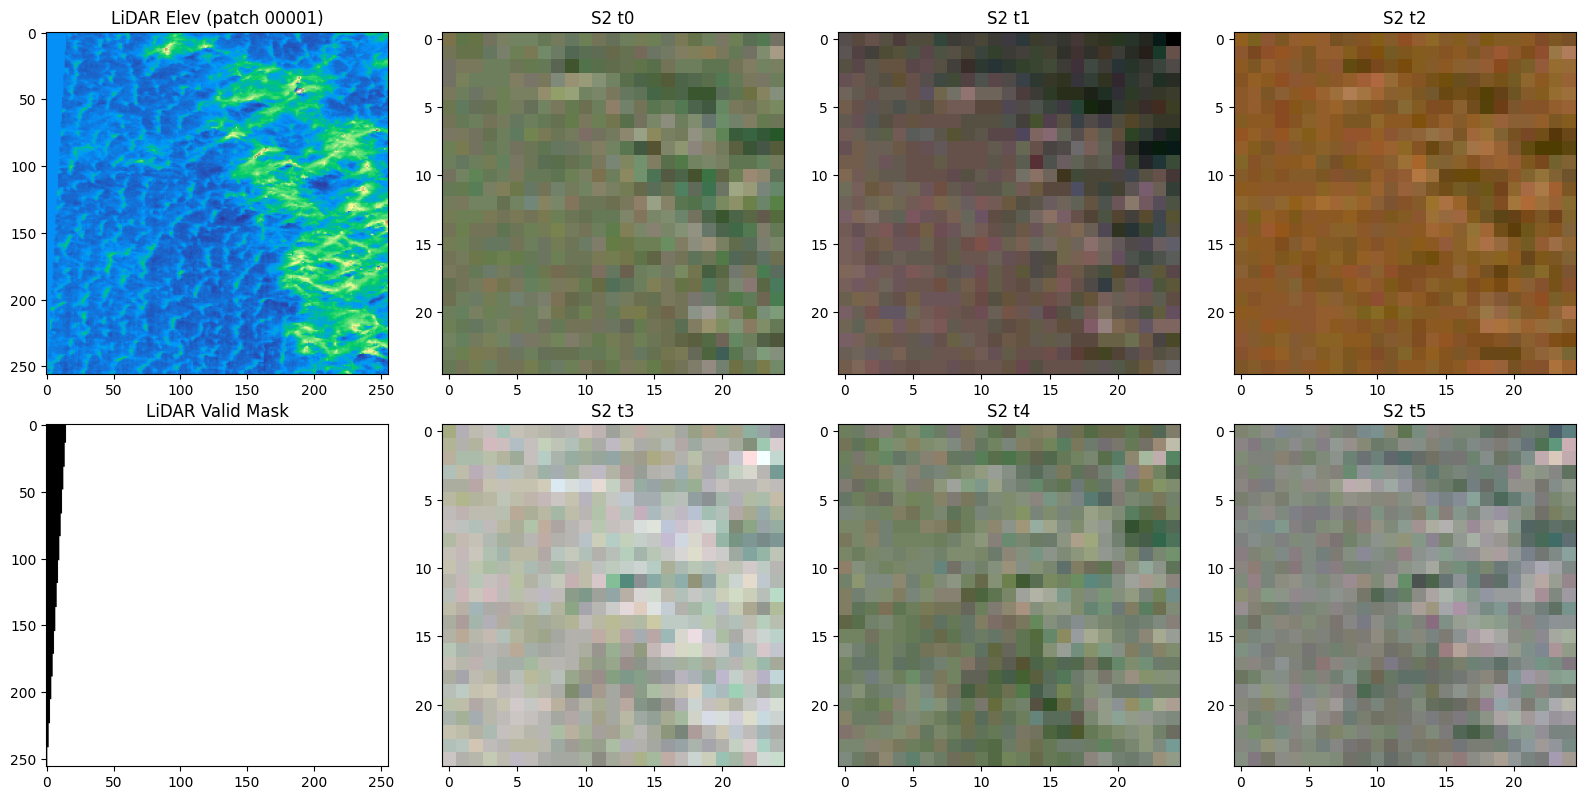

In [29]:
# Visualization with global normalization

def normalize_01(img):
    img = img.astype(np.float32)
    mn, mx = np.nanmin(img), np.nanmax(img)
    if mx <= mn:
        return np.zeros_like(img)
    return (img - mn) / (mx - mn)

def normalize_global(img, global_min, global_max):
    img = img.astype(np.float32)
    return (img - global_min) / (global_max - global_min)

def show_group(patch_id, out_lidar_dir, out_s2_dir):
    lid_path = os.path.join(out_lidar_dir, f"lidar_patch_{patch_id}.tif")
    s2_dir  = os.path.join(out_s2_dir, f"s2_patch_{patch_id}")

    with rasterio.open(lid_path) as src:
        lidar_elev = src.read(1)
        lidar_mask = src.read(2)

    s2_imgs = []
    for i in range(6):
        s2_path = os.path.join(s2_dir, f"t{i}.tif")
        with rasterio.open(s2_path) as src:
            rgb = src.read([1, 2, 3])
        rgb = np.moveaxis(rgb, 0, -1)
        s2_imgs.append(rgb)

    # Compute global means
    # Compute global min/max for each band across all patches
    global_min = np.nanmin(s2_imgs, axis=(0, 1, 2))
    global_max = np.nanmax(s2_imgs, axis=(0, 1, 2))

    # normalize each image using global min/max
    for i in range(6):
        s2_imgs[i] = normalize_global(s2_imgs[i], global_min, global_max)

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    ax = axes.ravel()

    im0 = ax[0].imshow(lidar_elev, cmap="terrain")
    ax[0].set_title(f"LiDAR Elev (patch {patch_id})")
    #plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

    im1 = ax[4].imshow(lidar_mask, cmap="gray")
    ax[4].set_title("LiDAR Valid Mask")
    #plt.colorbar(im1, ax=ax[4], fraction=0.046, pad=0.04)

    titles = [f"S2 t{i}" for i in range(6)]
    for i in range(3):
        ax[1 + i].imshow(s2_imgs[i])
        ax[1 + i].set_title(titles[i])
        ax[1 + i]

    for i in range(3, 6):
        ax[5 + (i - 3)].imshow(s2_imgs[i])
        ax[5 + (i - 3)].set_title(titles[i])
        ax[5 + (i - 3)]

    for a in ax:
        if not hasattr(a.images, "__len__") or len(a.images) == 0:
            a.axis("off")

    plt.tight_layout()
    plt.show()

# Example: Visualize example for report
sample_lidar = glob(os.path.join(out_lidar_dir, "lidar_patch_00001.tif"))
pid = os.path.splitext(os.path.basename(sample_lidar[0]))[0].split("_")[-1]
show_group(pid, out_lidar_dir, out_s2_dir)

Plot saved to noise_progression_subplots.png


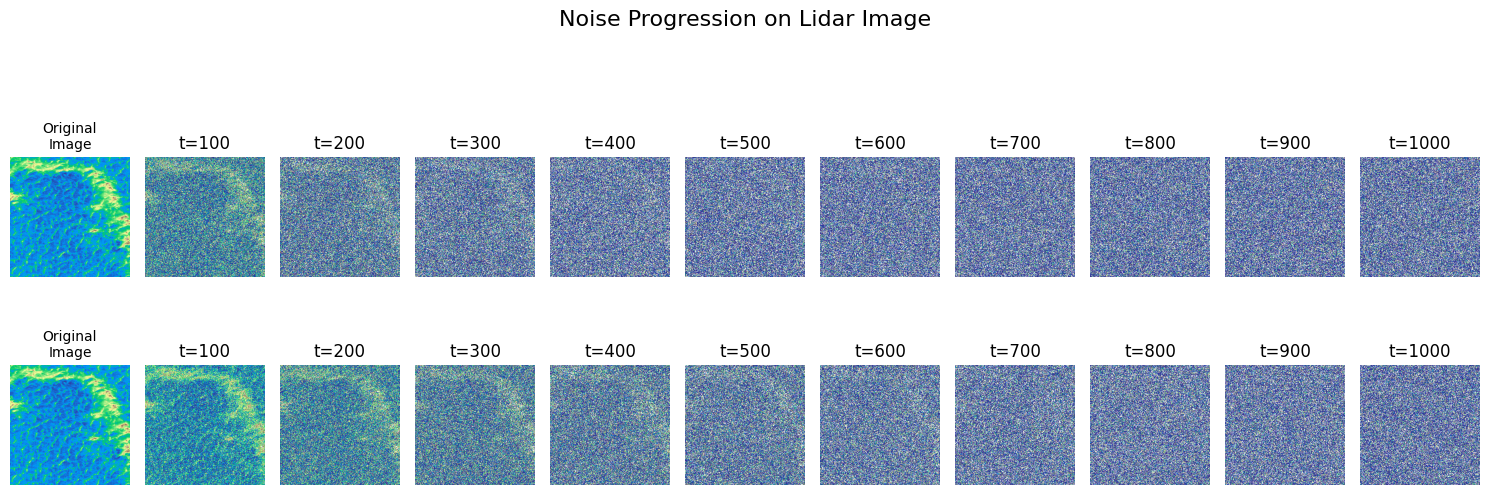

In [ ]:
# Noise progression visualization

class LinearDiffusionScheduler:
    def __init__(self, timesteps=1000):
        self.betas = np.linspace(0.0001, 0.02, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = np.cumprod(self.alphas)

    def add_noise(self, original_image, t):
        if t >= len(self.alphas_cumprod):
            t = len(self.alphas_cumprod) - 1
        alpha_bar_t = self.alphas_cumprod[t]
        noise = np.random.randn(*original_image.shape)
        noisy_image = np.sqrt(alpha_bar_t) * original_image + np.sqrt(1 - alpha_bar_t) * noise
        return noisy_image

class CosineDiffusionScheduler:
    def __init__(self, timesteps=1000):
        s = 0.008
        t_steps = np.arange(timesteps + 1)
        self.alphas_cumprod = np.cos(((t_steps / timesteps) + s) / (1 + s) * np.pi / 2) ** 2
        self.alphas_cumprod = self.alphas_cumprod / self.alphas_cumprod[0]

    def add_noise(self, original_image, t):
        if t >= len(self.alphas_cumprod):
            t = len(self.alphas_cumprod) - 1
        alpha_bar_t = self.alphas_cumprod[t]
        noise = np.random.randn(*original_image.shape)
        noisy_image = np.sqrt(alpha_bar_t) * original_image + np.sqrt(1 - alpha_bar_t) * noise
        return noisy_image

# Path to example .tif file
path_to_tif = "/cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/final/lidar_patches/lidar_patch_00014.tif"

# Load the LiDAR image
try:
    with rasterio.open(path_to_tif) as src:
        lidar_image = src.read(1)
except Exception as e:
    print(f"Error loading the .tif file: {e}")
    print("Using a placeholder image for demonstration.")
    lidar_image = np.random.rand(64, 64)

# Normalize image data to be between 0 and 1 for consistent plotting
min_val = lidar_image.min()
max_val = lidar_image.max()
lidar_image = (lidar_image - min_val) / (max_val - min_val)

# Define parameters for plotting
timesteps = 1000
num_samples_to_plot = 10
stride = timesteps // num_samples_to_plot
time_indices = np.arange(0, timesteps, stride)
if timesteps not in time_indices:
    time_indices = np.append(time_indices, timesteps)

# Initialize schedulers
linear_scheduler = LinearDiffusionScheduler(timesteps=timesteps)
cosine_scheduler = CosineDiffusionScheduler(timesteps=timesteps)

# Create the figure and subplots
fig, axes = plt.subplots(2, num_samples_to_plot+1, figsize=(15, 6))

# Plot for Linear Noise
for i, t_step in enumerate(time_indices):
    linear_noisy_image = linear_scheduler.add_noise(lidar_image, t=t_step)
    axes[0, i].imshow(linear_noisy_image, cmap='terrain',vmin=0, vmax=1)
    axes[0, i].set_title(f't={t_step}')
    axes[0, i].axis('off')

axes[0, 0].set_ylabel('Linear', rotation=90, size='large')
axes[0, 0].set_title(f'Original\nImage', fontsize=10)

# Plot for Cosine Noise
for i, t_step in enumerate(time_indices):
    cosine_noisy_image = cosine_scheduler.add_noise(lidar_image, t=t_step)
    axes[1, i].imshow(cosine_noisy_image, cmap='terrain',vmin=0, vmax=1)
    axes[1, i].set_title(f't={t_step}')
    axes[1, i].axis('off')

axes[1, 0].set_ylabel('Cosine', rotation=90, size='large')
axes[1, 0].set_title(f'Original\nImage', fontsize=10)

fig.suptitle('Noise Progression on Lidar Image', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('noise_progression_subplots.png')
print("Plot saved to noise_progression_subplots.png")
plt.show()